<a href="https://colab.research.google.com/github/Pavithra777/EVA-8-Phase-1/blob/main/Assignment%209/session9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
!wget https://raw.githubusercontent.com/Pavithra777/PavithraDevi/main/utils.py
!pip install torch_lr_finder
import utils

--2023-02-24 20:05:28--  https://raw.githubusercontent.com/Pavithra777/PavithraDevi/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7575 (7.4K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   7.40K  --.-KB/s    in 0s      

2023-02-24 20:05:29 (95.6 MB/s) - ‘utils.py’ saved [7575/7575]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
!wget https://raw.githubusercontent.com/Pavithra777/PavithraDevi/main/models/transformers.py
!pip install torch_lr_finder
import transformers as m

--2023-02-24 20:05:33--  https://raw.githubusercontent.com/Pavithra777/PavithraDevi/main/models/transformers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2029 (2.0K) [text/plain]
Saving to: ‘transformers.py’

transformers.py     100%[===================>]   1.98K  --.-KB/s    in 0s      

2023-02-24 20:05:33 (40.7 MB/s) - ‘transformers.py’ saved [2029/2029]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms
from tqdm import tqdm
import utils
import copy
import matplotlib.pyplot as plt

train_dataset_dict = utils.get_metadata_of_CIFAR10_train_dataset()
train_dataset = train_dataset_dict['dataset'] 

# train_agumentation = {A.Normalize((0.49139968, 0.48215841, 0.44653091),(0.24703223 ,0.24348513, 0.26158784)),
#                 A.HorizontalFlip(),
#                 A.CoarseDropout(max_holes=1,max_height=8,max_width=8,
#                               min_height=8,min_width=8,
#                               fill_value= 0.473363,mask_fill_value=None,always_apply=True),
#                 A.PadIfNeeded(min_height=36, min_width=36, p=0.2,always_apply=True),
#                 A.RandomCrop(32, 32, always_apply=True, p=0.2)
#                 }
train_agumentation = {A.Normalize((0.49139968, 0.48215841, 0.44653091),(0.24703223, 0.24348513, 0.26158784))
                }

test_agumentation = {A.Normalize((0.49139968, 0.48215841, 0.44653091),(0.24703223, 0.24348513, 0.26158784))
                }

Files already downloaded and verified
[Train]
-Numpy Shape : (50000, 32, 32, 3)
-min: [0. 0. 0.]
-max: [1. 1. 1.]
-mean: [0.49139968 0.48215841 0.44653091]
-std: [0.24703223 0.24348513 0.26158784]
-var: [15.56135559 15.11767693 17.44919073]
-classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [29]:
SEED=1
#CUDA?
cuda=torch.cuda.is_available()
print("CUDA Available:",cuda)

#For reproducibility
torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)
  BATCH_SIZE=64
else:
  BATCH_SIZE=64

train_loader,test_loader=utils.get_CIFAR10_dataset(train_agumentation,test_agumentation,BATCH_SIZE)

device= utils.get_device()
print(device)
#net=m.TransformerModel().to(device)

CUDA Available: True
Files already downloaded and verified
Files already downloaded and verified
device :  cuda
cuda


In [30]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class UltimusBlock(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(UltimusBlock, self).__init__()
		#X*K = 48*48x8 > 8
        self.K = nn.Linear(in_dim, out_dim*8)
		#X*Q = 48*48x8 > 8
        self.Q = nn.Linear(in_dim, out_dim*8)
		#X*V = 48*48x8 > 8
        self.V = nn.Linear(in_dim, out_dim*8)
        self.softmax = nn.Softmax(dim=1)
        self.out = nn.Linear(out_dim*8, in_dim)

    def forward(self, x):
        k = self.K(x)
        q = self.Q(x)
        v = self.V(x)
        k = k.view(k.size(0), 8, -1)
        q = q.view(q.size(0), 8, -1)
        v = v.view(v.size(0), 8, -1)
        
        am = self.softmax(torch.bmm(q.transpose(1, 2), k)) / 8 ** 0.5
        z = torch.bmm(v, am).view(v.size(0), -1)
        # AM = SoftMax(QTK)/(8^0.5) = 8*8 = 8
        #am = F.softmax(torch.matmul(q, k.t()) / (8 ** 0.5), dim=-1)

        # Z = V*AM = 8*8 > 8
        #z = torch.matmul(am, v)

        # Z*Out = 8*8x48 > 48
        return self.out(z)

class TransformerModel(nn.Module):
    def __init__(self):
        super(TransformerModel, self).__init__()
        
        #Add 3 Convolutions to arrive at AxAx48 dimensions (e.g. 32x32x3 | 3x3x3x16 >> 3x3x16x32 >> 3x3x32x48)
        self.conv1 = nn.Conv2d(3, 16, 3, stride=1,padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2,padding=1)
        self.conv3 = nn.Conv2d(32, 48, 3, stride=2,padding=1)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        
        # Repeat this Ultimus block 4 times
        self.ultimus1 = UltimusBlock(48, 8)
        self.ultimus2 = UltimusBlock(48, 8)
        self.ultimus3 = UltimusBlock(48, 8)
        self.ultimus4 = UltimusBlock(48, 8)
        
        # final fully connected layer
        self.fc = nn.Linear(48, 10)

    def forward(self, x):
        # pass through convolution layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        # Apply GAP and get 1x1x48, call this X
        x = self.global_avg_pool(x)
        x = x.view(-1,48)
        
        # pass through ultimus blocks
        x = self.ultimus1(x)
        x = self.ultimus2(x)
        x = self.ultimus3(x)
        x = self.ultimus4(x)
        
        # final FC layer that converts 48 to 10 
        x = self.fc(x)
        return x


In [31]:
net=TransformerModel().to(device)

In [32]:
import torch.nn as nn
criterion = nn.CrossEntropyLoss()

  0%|          | 0/118 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.96E-03


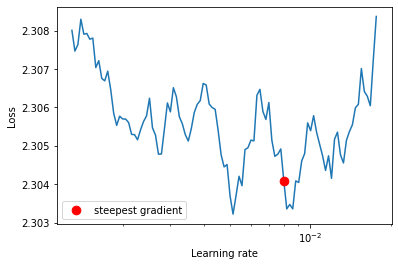

Max LR is 0.005148426624454633


In [33]:
net_exp = copy.deepcopy(net)
optimizer =  optim.Adam(net_exp.parameters(), lr=0.001, weight_decay=1e-4)
ler_rate = utils.find_lr(net_exp,optimizer,criterion,0.02,train_loader)

In [34]:
net1 = copy.deepcopy(net)
optimizer =  optim.Adam(net1.parameters(), lr=ler_rate, weight_decay=1e-4)

scheduler =utils.get_scheduler(optimizer,len(train_loader),ler_rate)

_,history =utils.fit_model(net1,device,train_loader,test_loader,scheduler,optimizer,NUM_EPOCHS=24,l1=False,l2=True)

EPOCH: 1


Batch_id=781 Loss=-1.62100 Accuracy=9.91: 100%|██████████| 782/782 [00:19<00:00, 40.78it/s]



 Test set : Average loss: -7.4005, Accuracy: 1000/10000 (10.00%)

EPOCH: 2


Batch_id=781 Loss=nan Accuracy=10.01: 100%|██████████| 782/782 [00:18<00:00, 41.99it/s]



 Test set : Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 3


Batch_id=781 Loss=nan Accuracy=10.00: 100%|██████████| 782/782 [00:20<00:00, 37.97it/s]



 Test set : Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 4


Batch_id=781 Loss=nan Accuracy=10.00: 100%|██████████| 782/782 [00:19<00:00, 40.38it/s]



 Test set : Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 5


Batch_id=781 Loss=nan Accuracy=10.00: 100%|██████████| 782/782 [00:18<00:00, 41.56it/s]



 Test set : Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 6


Batch_id=781 Loss=nan Accuracy=10.00: 100%|██████████| 782/782 [00:18<00:00, 41.75it/s]



 Test set : Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 7


Batch_id=781 Loss=nan Accuracy=10.00: 100%|██████████| 782/782 [00:21<00:00, 35.78it/s]



 Test set : Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 8


Batch_id=781 Loss=nan Accuracy=10.00: 100%|██████████| 782/782 [00:20<00:00, 39.08it/s]



 Test set : Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 9


Batch_id=781 Loss=nan Accuracy=10.00: 100%|██████████| 782/782 [00:21<00:00, 36.27it/s]



 Test set : Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 10


Batch_id=781 Loss=nan Accuracy=10.00: 100%|██████████| 782/782 [00:18<00:00, 41.36it/s]



 Test set : Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 11


Batch_id=781 Loss=nan Accuracy=10.00: 100%|██████████| 782/782 [00:20<00:00, 38.78it/s]



 Test set : Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 12


Batch_id=781 Loss=nan Accuracy=10.00: 100%|██████████| 782/782 [00:19<00:00, 39.25it/s]



 Test set : Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 13


Batch_id=781 Loss=nan Accuracy=10.00: 100%|██████████| 782/782 [00:19<00:00, 39.66it/s]



 Test set : Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 14


Batch_id=781 Loss=nan Accuracy=10.00: 100%|██████████| 782/782 [00:19<00:00, 40.55it/s]



 Test set : Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 15


Batch_id=781 Loss=nan Accuracy=10.00: 100%|██████████| 782/782 [00:21<00:00, 35.97it/s]



 Test set : Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 16


Batch_id=781 Loss=nan Accuracy=10.00: 100%|██████████| 782/782 [00:20<00:00, 38.68it/s]



 Test set : Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 17


Batch_id=781 Loss=nan Accuracy=10.00: 100%|██████████| 782/782 [00:18<00:00, 41.28it/s]



 Test set : Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 18


Batch_id=781 Loss=nan Accuracy=10.00: 100%|██████████| 782/782 [00:19<00:00, 40.17it/s]



 Test set : Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 19


Batch_id=781 Loss=nan Accuracy=10.00: 100%|██████████| 782/782 [00:20<00:00, 38.92it/s]



 Test set : Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 20


Batch_id=781 Loss=nan Accuracy=10.00: 100%|██████████| 782/782 [00:19<00:00, 39.50it/s]



 Test set : Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 21


Batch_id=781 Loss=nan Accuracy=10.00: 100%|██████████| 782/782 [00:20<00:00, 37.98it/s]



 Test set : Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 22


Batch_id=781 Loss=nan Accuracy=10.00: 100%|██████████| 782/782 [00:19<00:00, 39.94it/s]



 Test set : Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 23


Batch_id=781 Loss=nan Accuracy=10.00: 100%|██████████| 782/782 [00:20<00:00, 37.65it/s]



 Test set : Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 24


Batch_id=781 Loss=nan Accuracy=10.00: 100%|██████████| 782/782 [00:19<00:00, 39.15it/s]



 Test set : Average loss: nan, Accuracy: 1000/10000 (10.00%)



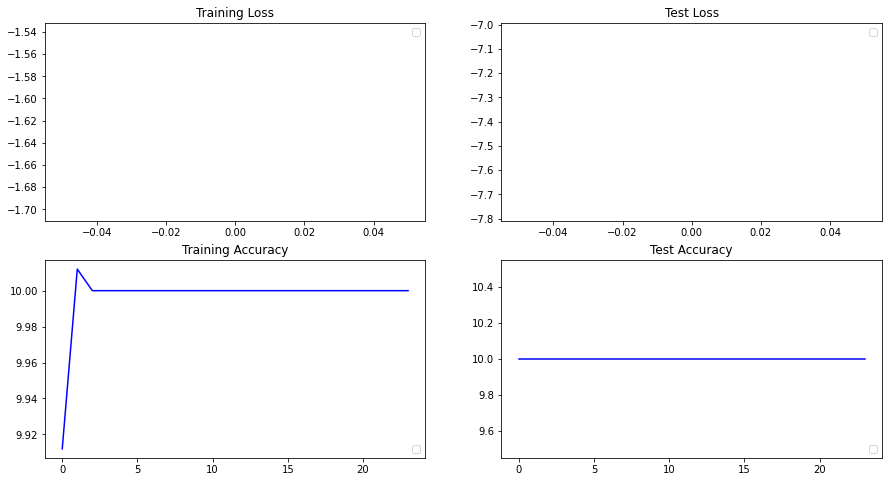

In [35]:
training_acc,training_loss,testing_acc,testing_loss = history

fig, axs = plt.subplots(2,2,figsize=(15,8))
axs[0, 0].plot(training_loss,color='r')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(training_acc,color='b')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(testing_loss,color='r')
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(testing_acc,color='b')
axs[1, 1].set_title("Test Accuracy")
leg = axs[0, 0].legend(loc='upper right')
leg = axs[0, 1].legend(loc='upper right')
leg = axs[1, 0].legend(loc='lower right')
leg = axs[1, 1].legend(loc='lower right')